In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt
import scipy as sc
mpl.rcParams.update({'font.size':20})

# Progress bar yay
from ipywidgets import FloatProgress

# Comparison of Different SQA Experimental Methods

### 1] Brief overview of the methods

We will compare three different methods that give rise to coherent qubit oscillations:
  * DWave's method by C. Deng *et al*. (retracted)
  * Magnetic Pulse method by [S. Poletto *et al*][1].
  * QEO's annealing methods.

[1]: https://iopscience.iop.org/article/10.1088/1367-2630/11/1/013009/pdf

### 2] DWave's Method

In [72]:
# X pulse
def x_pulse_ideal(tpts,p):
    if type(tpts) in [np.ndarray,list]:
        ret = np.zeros([len(tpts)])
        for i,t in enumerate(tpts):
            if t < p["xid"]:
                ret[i] = 0.0
            elif t >= p["xid"] and t <= p["xw"]+p["xid"]:
                ret[i] = 1.0
            elif t > p["xw"]+p["xid"]:
                ret[i] = 0.0
        return p["xA"]*ret
    else:
        if tpts < p["xid"]:
            return 0.0
        elif tpts >= p["xid"] and tpts <= p["xw"]+p["xid"]:
            return p["xA"]
        elif tpts > p["xw"]+p["xid"]:
            return 0.0

# Z pulse
def z_pulse_ideal(tpts,p):
    if type(tpts) in [np.ndarray,list]:
        ret = np.zeros([len(tpts)])
        for i,t in enumerate(tpts):
            if t < p["zid"]:
                ret[i] = 0.0
            elif t >= p["zid"] and t <= p["zw"]+p["zid"]:
                ret[i] = 1.0
            elif t > p["zw"]+p["zid"]:
                ret[i] = 0.0
        if not p["zrev"]:
            return p["zA"]*ret
        else:
            return p["zA"]*(1-ret)
    else:
        if not p["zrev"]:
            if tpts < p["zid"]:
                return 0.0
            elif tpts >= p["zid"] and tpts <= p["zw"]+p["zid"]:
                return p["zA"]
            elif tpts > p["zw"]+p["zid"]:
                return 0.0
        else:
            if tpts < p["zid"]:
                return p["zA"]
            elif tpts >= p["zid"] and tpts <= p["zw"]+p["zid"]:
                return 0.0
            elif tpts > p["zw"]+p["zid"]:
                return p["zA"]
        
# X pulse with rise time
def x_pulse(tpts,p):
    
    # Impulse reponse
    def T(t):
        return 1.0/p["tc"]*np.exp(-t/p["tc"])
    
    # Convolution callback
    def conv(tau,t,f,p):
        return sc.real(f(t-tau,p)*T(tau))
    
    if type(tpts) in [np.ndarray,list]:
        ret = np.zeros([len(tpts)])
        for i,t in enumerate(tpts):
            ret[i] = sc.integrate.quad(conv,0,t,args=(t,x_pulse_ideal,p))[0]
        return ret
    else:
        return sc.integrate.quad(conv,0,tpts,args=(tpts,x_pulse_ideal,p))[0]

# Z pulse with rise time
def z_pulse(tpts,p):
    
    # Impulse reponse
    def T(t):
        return 1.0/p["tc"]*np.exp(-t/p["tc"])
    
    # Convolution callback
    def conv(tau,t,f,p):
        return sc.real(f(t-tau-30*p["zw"],p)*T(tau))
    
    if type(tpts) in [np.ndarray,list]:
        ret = np.zeros([len(tpts)])
        for i,t in enumerate(tpts):
            ret[i] = sc.integrate.quad(conv,0,t+30*p["zw"],args=(t+30*p["zw"],z_pulse_ideal,p))[0]
        return ret
    else:
        return sc.integrate.quad(conv,0,tpts+30*p["zw"],args=(tpts+30*p["zw"],z_pulse_ideal,p))[0]

Text(0.5, 1.0, 'Z Pulse')

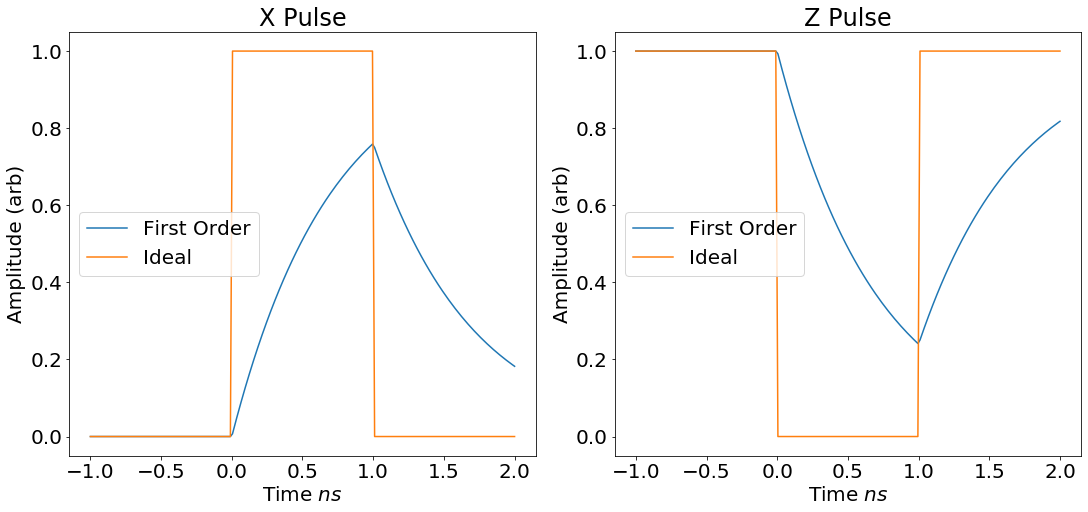

In [75]:
# Pulse parameters
px = {"xw":1.0,"xid":0.0,"tc":0.7,"xA":1,"zrev":False}
pz = {"zw":1.0,"zid":0.0,"tc":0.7,"zA":1,"zrev":True}
xpts = np.linspace(-px["xw"],2*px["xw"],201)

fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(15,7))
ax1 = ax[0]
ax2 = ax[1]
ax1.plot(xpts,x_pulse(xpts,px))
ax1.plot(xpts,x_pulse_ideal(xpts,px))
ax1.set_xlabel('Time $ns$')
ax1.set_ylabel('Amplitude (arb)')
ax1.legend(["First Order","Ideal"])
ax1.set_title("X Pulse")

ax2.plot(xpts,1-x_pulse(xpts,px))
ax2.plot(xpts,z_pulse_ideal(xpts,pz))
ax2.set_xlabel('Time $ns$')
ax2.set_ylabel('Amplitude (arb)')
ax2.legend(["First Order","Ideal"])
ax2.set_title("Z Pulse")

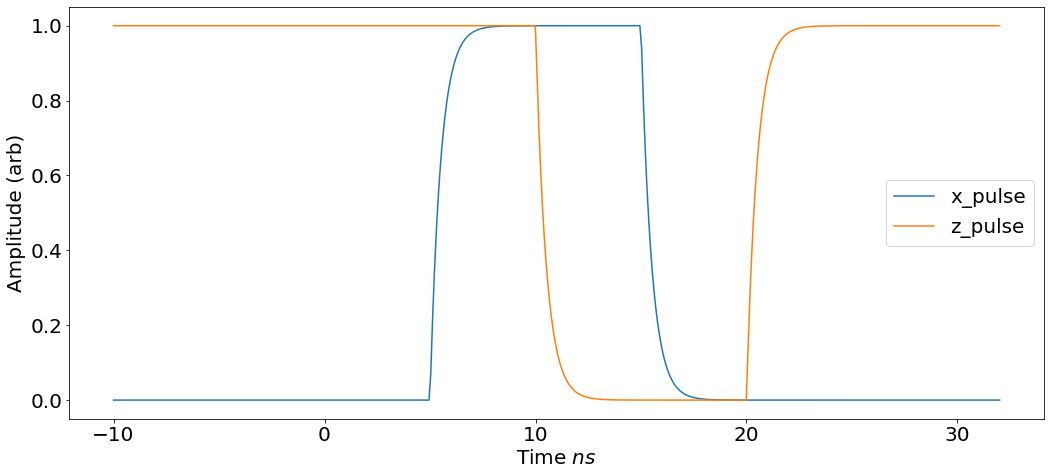

In [59]:
# Pulse parameters
p = {"tc":0.5,"xw":10.0,"xid":5.0,"xA":1,"zw":10.0,"zid":10.0+0.0,"zA":1,"zrev":True}

# Plot pulse sequence
fig = plt.figure(figsize=(15,7))

# Schedules
xpts = np.linspace(-p["xw"],2.0+p["zw"]+2*p["xw"],501)
ax1 = plt.subplot(111)
ax1.plot(xpts,x_pulse(xpts,p))
ax1.plot(xpts,z_pulse(xpts,p))
ax1.set_xlabel('Time $ns$')
ax1.set_ylabel('Amplitude (arb)')
ax1.legend(["x_pulse","z_pulse"])
fig.tight_layout()

In [62]:
# Maximum X tunneling and Z bias terms in GHz (angular frequency)
hx=0.2*2*np.pi
hz=0.2*2*np.pi

# Delay between removing Z bias and applying X pulse
init_delay = 0.0

# Delay before readout
delay_min = 0.0
delay_max = 15.0
delays = np.linspace(delay_min,delay_max,201)

# Hamiltonian at t=0
H0 = hz*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

def z_func(tpts,p):
    if type(tpts) in [np.ndarray,list]:
        return p["zA"]*np.array([1.0]*len(tpts))
    else:
        return p["zA"]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# x_pulse(t)sigma_x
H = [[qt.sigmax(),x_pulse],[qt.sigmaz(),z_func]]
#H = [[qt.sigmax(),x_pulse],[qt.sigmaz(),z_pulse]]

# Operator states
sz,zstates=qt.sigmaz().eigenstates()
sy,ystates=qt.sigmay().eigenstates()
sx,xstates=qt.sigmax().eigenstates()

# Setup progress bar
f = FloatProgress(min=0, max=len(delays))
print("'tan' sweep progress:")
display(f)

# Use the Lindblad master equation solver
pop0_zdm1 = []
pop0_ydm1 = []
pop0_xdm1 = []
for delay in delays:
    # Pulse parameters
    p = {"tc":0.07,"xw":1.0,"xid":5.0,"xA":hx,"zw":1.0,"zid":5.0,"zA":hz,"zrev":True}
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    #result = qt.mesolve(H, psi0, times, [], [], args={"w":20.0,"id":5.0,"tc":2.0}, options=qt.Options(nsteps=10000))
    times = np.array([0.0,delay])
    result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=10000))
    
    # Save relevant results
    pop0_zdm1.append(qt.expect(qt.ket2dm(zstates[0]),result.states[1]))
    pop0_ydm1.append(qt.expect(qt.ket2dm(ystates[0]),result.states[1]))
    pop0_xdm1.append(qt.expect(qt.ket2dm(xstates[0]),result.states[1]))
    f.value+=1


'tan' sweep progress:


FloatProgress(value=0.0, max=201.0)

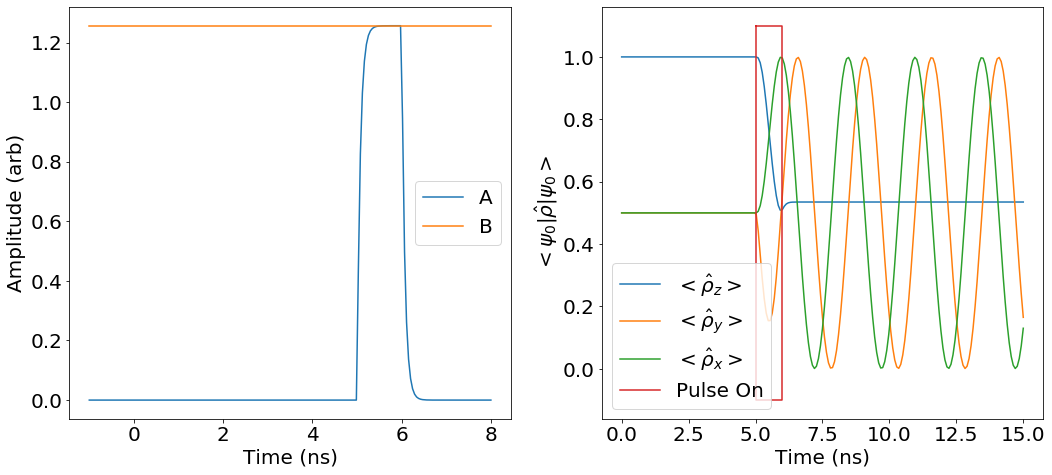

In [64]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# X pulse
xpts = np.linspace(-p["xw"],p["xid"] + 3*p["xw"],201)
ax1 = plt.subplot(121)
ax1.plot(xpts,x_pulse(xpts,p))
ax1.plot(xpts,z_func(xpts,p))
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Amplitude (arb)')
ax1.legend(["A","B"])
fig.tight_layout()

# Oscillations
ax2 = plt.subplot(122)
ax2.plot(delays, pop0_zdm1)
ax2.plot(delays, pop0_ydm1)
ax2.plot(delays, pop0_xdm1)
ax2.plot([5.0,5.0+p["xw"],5.0+p["xw"],5.0,5.0],[1.1,1.1,-0.1,-0.1,1.1])
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('$<\psi_0|\hat{\\rho}|\psi_0>$')
ax2.legend(["$<\hat{\\rho}_z>$","$<\hat{\\rho}_y>$","$<\hat{\\rho}_x>$","Pulse On"])

fig.tight_layout()

In [84]:
# Maximum X tunneling and Z bias terms in GHz (angular frequency)
hx=5*2*np.pi
hz=5*2*np.pi

# Delay between removing Z bias and applying X pulse
init_delay = 0.0

# Delay before readout
pl_min = 0.0
pl_max = 20.0
pls = np.linspace(pl_min,pl_max,201)

# Circuit first order time constant
TC = 0.07

# Hamiltonian at t=0
H0 = hz*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

def z_func(tpts,p):
    if type(tpts) in [np.ndarray,list]:
        return p["zA"]*np.array([1.0]*len(tpts))
    else:
        return p["zA"]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# x_pulse(t)sigma_x
H = [[qt.sigmax(),x_pulse],[qt.sigmaz(),z_func]]
#H = [[qt.sigmax(),x_pulse],[qt.sigmaz(),z_pulse]]

# Operator states
sz,zstates=qt.sigmaz().eigenstates()
sy,ystates=qt.sigmay().eigenstates()
sx,xstates=qt.sigmax().eigenstates()

# Setup progress bar
f = FloatProgress(min=0, max=len(delays))
print("'tan' sweep progress:")
display(f)

# Use the Lindblad master equation solver
pop0_zdm1 = []
pop0_ydm1 = []
pop0_xdm1 = []
for pl in pls:
    # Pulse parameters
    p = {"tc":TC,"xw":pl,"xid":0.0,"xA":hx,"zw":1.0,"zid":0.0,"zA":hz,"zrev":True}
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    #result = qt.mesolve(H, psi0, times, [], [], args={"w":20.0,"id":5.0,"tc":2.0}, options=qt.Options(nsteps=10000))
    times = np.array([0.0,pl+10*TC])
    result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=10000))
    
    # Save relevant results
    pop0_zdm1.append(qt.expect(qt.ket2dm(zstates[0]),result.states[1]))
    pop0_ydm1.append(qt.expect(qt.ket2dm(ystates[0]),result.states[1]))
    pop0_xdm1.append(qt.expect(qt.ket2dm(xstates[0]),result.states[1]))
    f.value+=1


'tan' sweep progress:


FloatProgress(value=0.0, max=201.0)

/home/dustyd/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


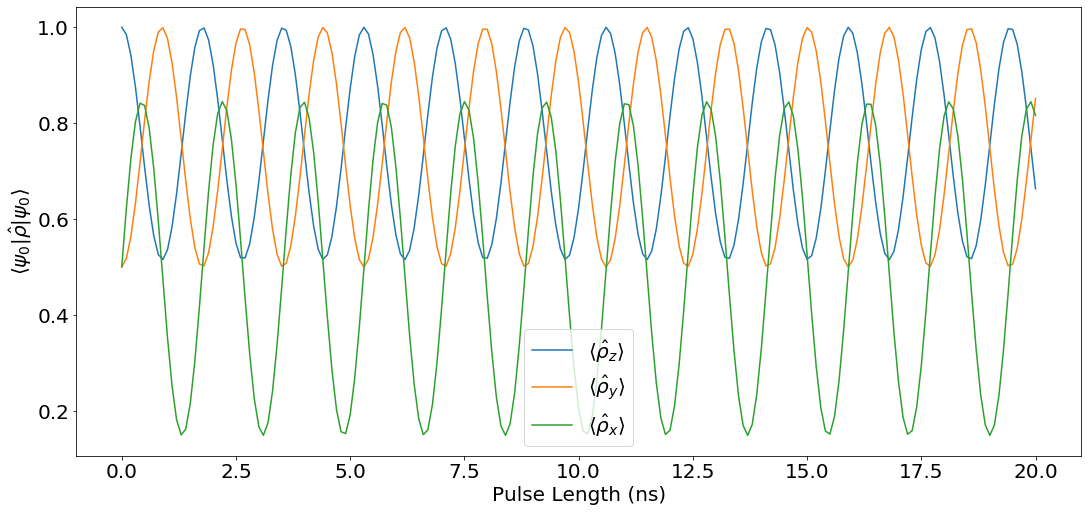

In [83]:
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(15,7))
ax.plot(pls, pop0_zdm1)
ax.plot(pls, pop0_ydm1)
ax.plot(pls, pop0_xdm1)
ax.set_xlabel('Pulse Length (ns)')
ax.set_ylabel('$\\langle\psi_0|\hat{\\rho}|\psi_0\\rangle$')
ax.legend(["$\\langle\hat{\\rho}_z\\rangle$","$\\langle\hat{\\rho}_y\\rangle$","$\\langle\hat{\\rho}_x\\rangle$","Pulse On"])

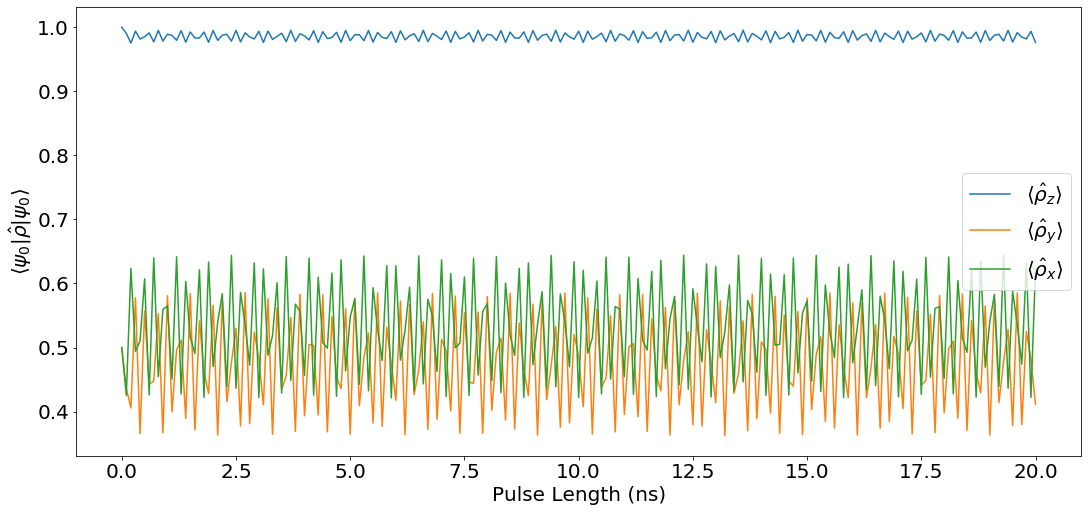

In [85]:
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(15,7))
ax.plot(pls, pop0_zdm1)
ax.plot(pls, pop0_ydm1)
ax.plot(pls, pop0_xdm1)
ax.set_xlabel('Pulse Length (ns)')
ax.set_ylabel('$\\langle\psi_0|\hat{\\rho}|\psi_0\\rangle$')
ax.legend(["$\\langle\hat{\\rho}_z\\rangle$","$\\langle\hat{\\rho}_y\\rangle$","$\\langle\hat{\\rho}_x\\rangle$","Pulse On"])

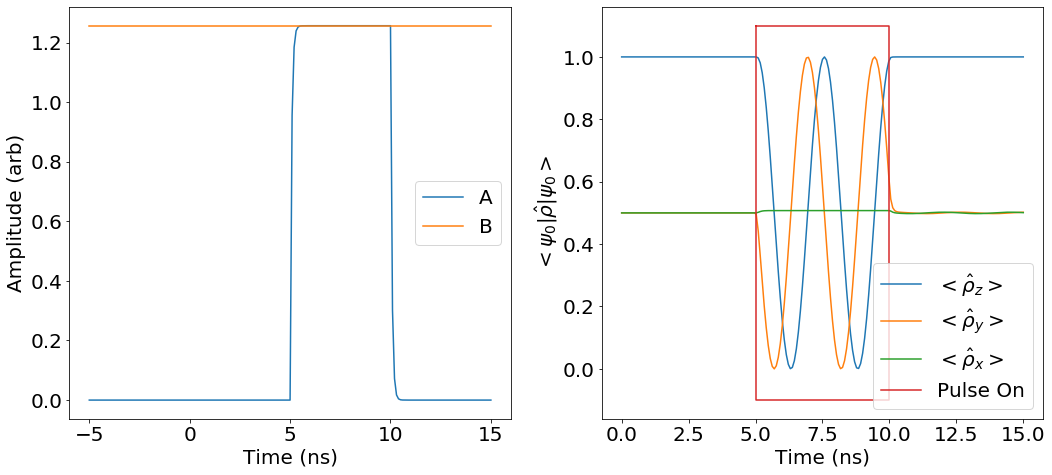

In [61]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# X pulse
xpts = np.linspace(-p["xw"],3*p["xw"],201)
ax1 = plt.subplot(121)
ax1.plot(xpts,x_pulse(xpts,p))
ax1.plot(xpts,z_func(xpts,p))
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Amplitude (arb)')
ax1.legend(["A","B"])
fig.tight_layout()

# Oscillations
ax2 = plt.subplot(122)
ax2.plot(delays, pop0_zdm1)
ax2.plot(delays, pop0_ydm1)
ax2.plot(delays, pop0_xdm1)
ax2.plot([5.0,5.0+p["xw"],5.0+p["xw"],5.0,5.0],[1.1,1.1,-0.1,-0.1,1.1])
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('$<\psi_0|\hat{\\rho}|\psi_0>$')
ax2.legend(["$<\hat{\\rho}_z>$","$<\hat{\\rho}_y>$","$<\hat{\\rho}_x>$","Pulse On"])

fig.tight_layout()

In [97]:
# Maximum X tunneling and Z bias terms in GHz (angular frequency)
hx=0.5*2*np.pi
hz=0.5*2*np.pi

# Delay between removing Z bias and applying X pulse
init_delay = 0.0

# Delay before readout
delay_min = 0.0
delay_max = 15.0
delays = np.linspace(delay_min,delay_max,201)

# Hamiltonian at t=0
H0 = hz*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# x_pulse(t)sigma_x
H = [[qt.sigmax(),x_pulse_ideal],[qt.sigmaz(),z_pulse_ideal]]

# Operator states
sz,zstates=qt.sigmaz().eigenstates()
sy,ystates=qt.sigmay().eigenstates()
sx,xstates=qt.sigmax().eigenstates()

# Setup progress bar
f = FloatProgress(min=0, max=len(delays))
print("'tan' sweep progress:")
display(f)

# Use the Lindblad master equation solver
pop0_zdm1 = []
pop0_ydm1 = []
pop0_xdm1 = []
for delay in delays:
    # Pulse parameters
    p = {"tc":0.07,"xw":1.0,"xid":0.0,"xA":hx,"zw":10.0,"zid":1.0+delay,"zA":hz}
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    #result = qt.mesolve(H, psi0, times, [], [], args={"w":20.0,"id":5.0,"tc":2.0}, options=qt.Options(nsteps=10000))
    times = np.array([0.0,delay + p["xw"]+0.1])
    result = qt.mesolve(H, psi0, times, [], [], args=p)
    
    # Save relevant results
    pop0_zdm1.append(qt.expect(qt.ket2dm(zstates[0]),result.states[1]))
    pop0_ydm1.append(qt.expect(qt.ket2dm(ystates[0]),result.states[1]))
    pop0_xdm1.append(qt.expect(qt.ket2dm(xstates[0]),result.states[1]))
    f.value+=1


'tan' sweep progress:


FloatProgress(value=0.0, max=201.0)

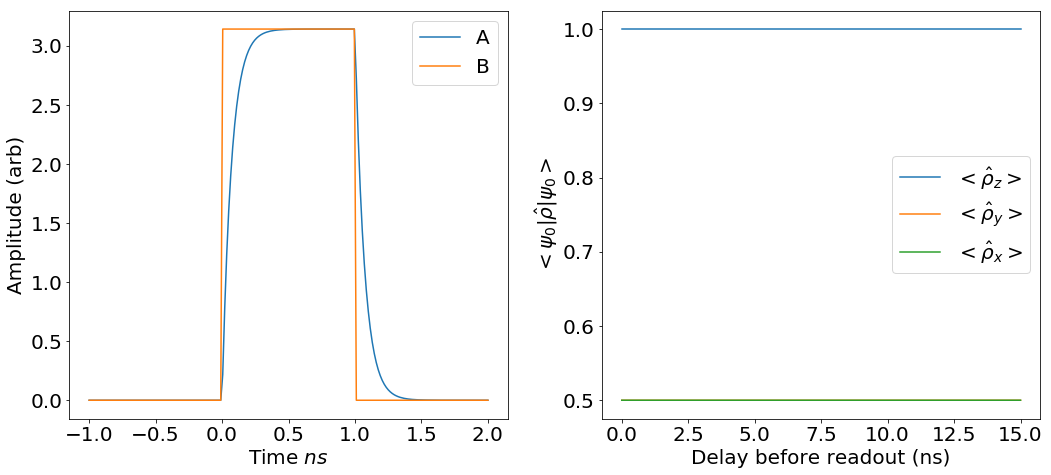

In [98]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# X pulse
xpts = np.linspace(-p["xw"],2*p["xw"],201)
ax1 = plt.subplot(121)
ax1.plot(xpts,x_pulse(xpts,p))
ax1.plot(xpts,x_pulse_ideal(xpts,p))
ax1.set_xlabel('Time $ns$')
ax1.set_ylabel('Amplitude (arb)')
ax1.legend(["A","B"])
fig.tight_layout()

# Oscillations
ax2 = plt.subplot(122)
ax2.plot(delays, pop0_zdm1)
ax2.plot(delays, pop0_ydm1)
ax2.plot(delays, pop0_xdm1)
ax2.set_xlabel('Delay before readout (ns)')
ax2.set_ylabel('$<\psi_0|\hat{\\rho}|\psi_0>$')
ax2.legend(["$<\hat{\\rho}_z>$","$<\hat{\\rho}_y>$","$<\hat{\\rho}_x>$"])

fig.tight_layout()